## Applied Deep Learning in Intracranial Neurophysiology Workshop
### Adversarial Domain Adaptation for Stable Brain-Machine Interfaces https://arxiv.org/pdf/1810.00045.pdf

This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL), prepared generously by [Dr. Ali Farshchian](https://www.researchgate.net/profile/Ali_Farshchian). The original version can be found on his [GitHub page](https://github.com/farshchian/ADAN).

<table><td><a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/08_01_ADAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td></table>

### Dependencies

In [1]:
# Normalize local and google colab environments.
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    os.chdir('..')
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    # !pip install -q tensorflow-gpu==2.0.0-rc0
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)

In [2]:
import tensorflow as tf
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
from indl.adan import utils
from indl import reset_keras
from tqdm import tqdm_notebook

plt.rcParams.update({'font.size': 22})

### Loading Data

In [7]:
datadir = Path.cwd() / 'data' / 'ADAN'
data = {}
for i, f in enumerate(datadir.glob('*.mat')):
    raw_data = sio.loadmat(datadir/f, squeeze_me=True)
    data['rate' + str(i)], data['EMG' + str(i)] = utils.load_data(raw_data)

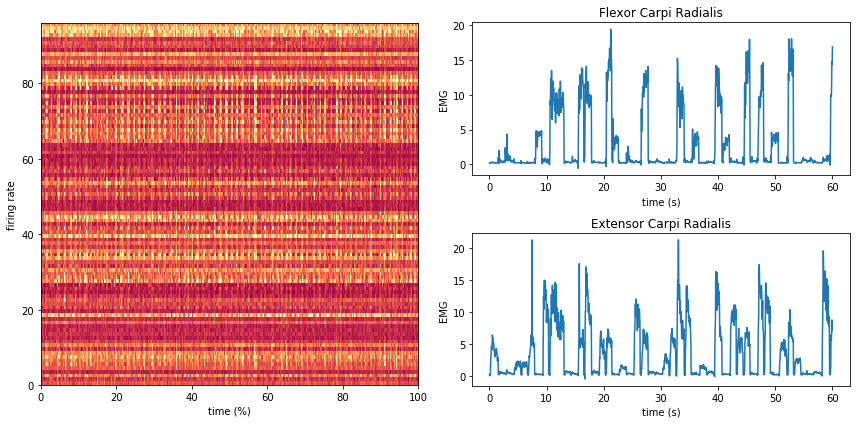

In [8]:
plt.figure(figsize=(12,6), facecolor='white')

plt.subplot(2, 2, (1,3))
plt.imshow(np.transpose(data['rate0']),cmap='Spectral',extent=[0,100,0,96])
plt.xlabel('time (%)')
plt.ylabel('firing rate')

plt.subplot(2, 2, 2)
t = np.linspace(0., 60., 1200, endpoint=True)
plt.plot(t,data['EMG0'][:1200,0])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Flexor Carpi Radialis')

plt.subplot(2, 2, 4)
plt.plot(t,data['EMG0'][:1200,11])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Extensor Carpi Radialis')

plt.tight_layout()
plt.show()

## Day-0 Decoder
![ADAN](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/img/ADAN.png?raw=1)

### Decoder Hyperparameters

In [9]:
spike_dim = 96
emg_dim = 14
latent_dim = 10
batch_size = 64
n_steps = 4
n_layers = 1
n_epochs = 400
lr = 0.001

### Decoder Graph

In [12]:
def make_model(spk_dim, emg_dim, n_steps, n_rnn_layers, n_units=[64, 32, latent_dim]):
    # Define encoder
    _spk = tf.keras.layers.Input(shape=(None, spk_dim), name='enc_input')
    _y = tf.keras.layers.Dense(units=n_units[0], activation=tf.nn.elu, name='enc_0')(_spk)
    _y = tf.keras.layers.Dense(units=n_units[1], activation=tf.nn.elu, name='enc_1')(_y)
    _latent = tf.keras.layers.Dense(units=n_units[2], activation=None, name='enc_lat')(_y)
    
    # Define spike decoder - latent as input
    _y = tf.keras.layers.Dense(units=n_units[1], activation=tf.nn.elu, name='dec_lat')(_latent)
    _y = tf.keras.layers.Dense(units=n_units[0], activation=tf.nn.elu, name='dec_spk_1')(_y)
    _spk_hat = tf.keras.layers.Dense(units=spk_dim, activation=tf.nn.elu, name='dec_spk_0')(_y)
    
    # Define emg decoder - also has latent as input
    _y2 = tf.keras.layers.Reshape((n_steps, n_units[2]), name='dec_emg_reshape_in')(_latent)
    _cells = [tf.keras.layers.LSTMCell(emg_dim, activation=tf.nn.elu)
              for _ in range(n_rnn_layers)]
    _stacked_cell = tf.keras.layers.StackedRNNCells(_cells)
    _y2 = tf.keras.layers.RNN(_stacked_cell, name='dec_emg_rnn')(_y2)
    _y2 = tf.keras.layers.Dense(units=emg_dim, activation=None, name='dec_emg_fc')(_y2)
    _emg_hat = tf.keras.layers.Reshape((-1, emg_dim), name='dec_emg_reshape_out')(_y2)
    
    model = tf.keras.Model(inputs=_spk, outputs=(_latent, _spk_hat, _emg_hat))
    
    # TODO: model.add_loss ... but will that work with gamma?
    
    return model

reset_keras()
model = make_model(spike_dim, emg_dim, n_steps, n_layers, n_units=[64, 32, latent_dim])
model.summary()

280
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, None, 96)]   0                                            
__________________________________________________________________________________________________
enc_0 (Dense)                   (None, None, 64)     6208        enc_input[0][0]                  
__________________________________________________________________________________________________
enc_1 (Dense)                   (None, None, 32)     2080        enc_0[0][0]                      
__________________________________________________________________________________________________
enc_lat (Dense)                 (None, None, 10)     330         enc_1[0][0]                      
__________________________________________________________________________________________

### Decoder Losses and Optimizers

In [34]:
def model_loss(spk, emg, spk_hat, emg_hat, gamma=0.5):
    ae_loss = tf.reduce_mean(tf.square(spk_hat - spk))
    emg_loss = tf.reduce_mean(tf.square(emg_hat - emg))
    total_loss = gamma * ae_loss + emg_loss
    new_gamma = emg_loss / ae_loss
    return total_loss, new_gamma

In [0]:
ae_loss = tf.reduce_mean(tf.square(logits - spike))
emg_loss = tf.reduce_mean(tf.square(emg_hat - emg))
total_loss = gamma*ae_loss+emg_loss
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(total_loss)

### Training and Test Set

In [35]:
spike_day0 = data['rate0']
emg_day0 = data['EMG0']
idx = int((len(spike_day0)//n_steps)*n_steps*0.82)
r = len(spike_day0)%n_steps

spike_tr = spike_day0[:idx]
emg_tr = emg_day0[:idx]
spike_te = spike_day0[idx:-r]
emg_te = emg_day0[idx:-r]

### Decoder Training

In [36]:
@tf.function
def model_step(model, inputs, optimizer, gamma=0.5):
    spk, emg = inputs
    with tf.GradientTape() as tape:
        latent, spk_hat, emg_hat = model(spk)
        loss_value, gamma = model_loss(spk, emg, spk_hat, emg_hat, gamma=gamma)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value, gamma

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
gamma = np.float32(1.)
n_batches = idx // batch_size
train_loss = []
valid_loss = []

for epoch_ix in range(1, n_epochs + 1):
    spike_gen_obj = utils.get_batches(spike_tr, batch_size)
    emg_gen_obj = utils.get_batches(emg_tr, batch_size)
    epoch_loss = []
    for step_ix in range(n_batches):
        inputs = next(spike_gen_obj), next(emg_gen_obj)
        loss, gamma = model_step(model, inputs, optimizer, gamma)
        epoch_loss.append(loss)
    train_loss.append(np.mean(epoch_loss))
        
    valid_loss = []
    for step_ix, inputs in enumerate(ds_valid):
        loss, gamma = model_step(model, inputs, optimizer, gamma)
        valid_loss.append(loss)
    valid_loss.append(np.mean(valid_loss))

W0920 17:01:56.973721 140214720902976 base_layer.py:1772] Layer enc_0 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



ValueError: in converted code:

    <ipython-input-36-1002b489691d>:5 model_step  *
        latent, spk_hat, emg_hat = model(spk)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py:807 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/network.py:697 call
        return self._run_internal_graph(inputs, training=training, mask=mask)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/network.py:842 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py:807 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/keras/layers/core.py:471 call
        (array_ops.shape(inputs)[0],) + self.target_shape)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:131 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_array_ops.py:8117 reshape
        "Reshape", tensor=tensor, shape=shape, name=name)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py:793 _apply_op_helper
        op_def=op_def)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py:548 create_op
        compute_device)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:3429 _create_op_internal
        op_def=op_def)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1773 __init__
        control_input_ops)
    /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1613 _create_c_op
        raise ValueError(str(e))

    ValueError: Cannot reshape a tensor with 640 elements to shape [64,4,10] (2560 elements) for 'model/dec_emg_reshape_in/Reshape' (op: 'Reshape') with input shapes: [64,10], [3] and with input tensors computed as partial shapes: input[1] = [64,4,10].


In [12]:
n_batches = idx // batch_size
gamma_ = np.float32(1.)
saver = tf.train.Saver(max_to_keep=1)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    for epoch in tqdm_notebook(range(n_epochs)):
        spike_gen_obj = utils.get_batches(spike_tr, batch_size)
        emg_gen_obj = utils.get_batches(emg_tr, batch_size)
        for ii in range(n_batches):
            spike_batch = next(spike_gen_obj)
            emg_batch = next(emg_gen_obj)
            sys.stdout.flush()
            sess.run(optimizer,feed_dict={spike:spike_batch,emg:emg_batch,gamma:gamma_})
        ae_loss_ = ae_loss.eval(feed_dict={spike:spike_tr,emg:emg_tr,gamma:gamma_})
        emg_loss_ = emg_loss.eval(feed_dict={spike:spike_tr,emg:emg_tr,gamma:gamma_})
        gamma_ = emg_loss_/ae_loss_
        if (epoch % 50 == 0) or (epoch == n_epochs-1): 
            spike_hat_tr,spike_hat_te = [logits.eval(feed_dict={spike:spike_tr}),logits.eval(feed_dict={spike:spike_te})]
            emg_hat_tr,emg_hat_te = [emg_hat.eval(feed_dict={spike:spike_tr,emg:emg_tr}),
                                     emg_hat.eval(feed_dict={spike:spike_te,emg:emg_te})]
            print("Epoch:", epoch, "\tAE_loss:",ae_loss_, "\tEMG_loss:",emg_loss_)
            print("AE Train %VAF:", utils.vaf(spike_tr,spike_hat_tr),"\AE Test %VAF:", utils.vaf(spike_te,spike_hat_te))
            print("EMG Train %VAF:", utils.vaf(emg_tr,emg_hat_tr),"\EMG Test %VAF:", utils.vaf(emg_te,emg_hat_te))
    saver.save(sess, "./Models/decoder")

Epoch: 0 	AE_loss: 0.7233407 	EMG_loss: 12.298606
AE Train %VAF: 41.39422736322217 \AE Test %VAF: 40.74873427821646
EMG Train %VAF: 23.116666421759035 \EMG Test %VAF: 23.843411836415772
Epoch: 50 	AE_loss: 0.23736988 	EMG_loss: 1.4445971
AE Train %VAF: 81.44729384274825 \AE Test %VAF: 81.64812727633922
EMG Train %VAF: 89.98143833400948 \EMG Test %VAF: 83.71880824833899
Epoch: 100 	AE_loss: 0.22136791 	EMG_loss: 1.2828474
AE Train %VAF: 82.51214162627495 \AE Test %VAF: 82.18251758838974
EMG Train %VAF: 91.13585926645122 \EMG Test %VAF: 84.92116384003351
Epoch: 150 	AE_loss: 0.21848807 	EMG_loss: 1.3099432
AE Train %VAF: 82.88044604771184 \AE Test %VAF: 81.98286024815685
EMG Train %VAF: 91.02678099430523 \EMG Test %VAF: 85.22746168573299
Epoch: 200 	AE_loss: 0.20904464 	EMG_loss: 1.0065576
AE Train %VAF: 83.3832064669731 \AE Test %VAF: 81.97542076126517
EMG Train %VAF: 93.04650107478074 \EMG Test %VAF: 82.9399477574772
Epoch: 250 	AE_loss: 0.20954631 	EMG_loss: 1.0991617
AE Train %VAF: 8

### EMG Predictions (Day-0)

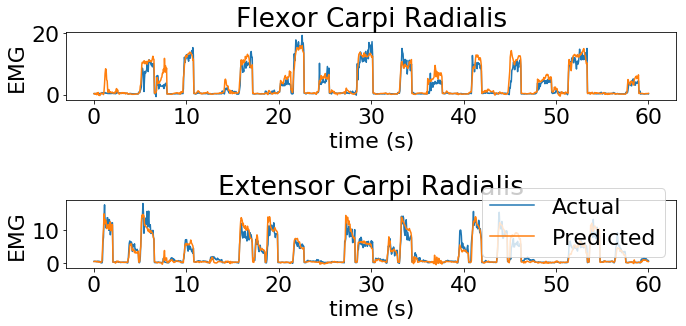

In [13]:
t = np.linspace(0., 60., 1056, endpoint=True)
plt.figure(figsize=(10,5), facecolor='white')

plt.subplot(2,1,1)
plt.plot(t,emg_te[:1056,0],t,emg_hat_te[:1056,0])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Flexor Carpi Radialis')

plt.subplot(2,1,2)
plt.plot(t,emg_te[:1056,11],t,emg_hat_te[:1056,11])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Extensor Carpi Radialis')
plt.legend(('Actual','Predicted'))

plt.tight_layout()
plt.show()

## Domain Adaptation
![ADAN2](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/img/ADAN2.png?raw=1)

### ADAN Hyperparameters

In [0]:
n_epochs = 50
batch_size = 16
d_lr = 0.00001
g_lr = 0.0001

### ADAN Graph

In [0]:
tf.reset_default_graph()
tf.set_random_seed(seed=42)

g = tf.train.import_meta_graph('./Models/decoder.meta')
graph = tf.get_default_graph()
spike = graph.get_tensor_by_name("spike:0")
emg_hat =  graph.get_tensor_by_name(name="emg_hat:0")

input_day0 = tf.placeholder(tf.float32, (None, spike_dim), name='input_day0')
input_dayk = tf.placeholder(tf.float32, (None, spike_dim), name='input_dayk')

def generator(input_, reuse=False):
    with tf.variable_scope('generator',initializer=tf.initializers.identity(),reuse=reuse):
        h1 = tf.layers.dense(input_,spike_dim,activation=None)
        output  = tf.layers.dense(h1,spike_dim,activation=None)
    return output

def discriminator(input_, n_units=[64,32,latent_dim], reuse=False):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        noise = tf.random_normal(tf.shape(input_), dtype=tf.float32)
        input_ = input_+noise
        h1 = tf.layers.dense(input_, units=n_units[0], activation=tf.nn.elu)
        h2 = tf.layers.dense(h1, units=n_units[1], activation=tf.nn.elu)
        latent = tf.layers.dense(h2, units=n_units[2], activation=None)
        h3 = tf.layers.dense(latent, units=n_units[1], activation=tf.nn.elu)
        h4 = tf.layers.dense(h3, units=n_units[0], activation=tf.nn.elu)
        logits = tf.layers.dense(h4, units=spike_dim, activation=None)
        return latent, logits

input_dayk_aligned = generator(input_dayk)
latent_day0,logits_day0 = discriminator(input_day0)
latent_dayk,logits_dayk = discriminator(input_dayk_aligned)

### ADAN Losses and Optimizers

In [0]:
d_loss_0 = tf.reduce_mean(tf.abs(logits_day0-input_day0)) 
d_loss_k = tf.reduce_mean(tf.abs(logits_dayk-input_dayk_aligned))
d_loss = d_loss_0 - d_loss_k
g_loss = d_loss_k

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_opt = tf.train.AdamOptimizer(learning_rate=d_lr).minimize(d_loss, var_list=d_vars)
g_opt = tf.train.AdamOptimizer(learning_rate=g_lr).minimize(g_loss, var_list=g_vars)

### ADAN Training

In [17]:
r = len(data['rate1'])%n_steps
spike_dayk = data['rate1'][:-r]
emg_dayk = data['EMG1'][:-r] 
n_batches = min(len(spike_day0),len(spike_dayk))//(batch_size)

a_vars = [var.name for var in t_vars if var.name.startswith('autoencoder')]
for i,name in enumerate(a_vars):
    tf.train.init_from_checkpoint('./Models/', {name[:-2]:d_vars[i]})

init = tf.global_variables_initializer()
with tf.Session() as sess: 
        init.run()
        g.restore(sess, tf.train.latest_checkpoint('./Models/'))
        for epoch in tqdm_notebook(range(n_epochs)):
            spike_0_gen_obj = utils.get_batches(spike_day0,batch_size)
            spike_k_gen_obj = utils.get_batches(spike_dayk,batch_size)
            for ii in range(n_batches):
                spike_0_batch = next(spike_0_gen_obj)
                spike_k_batch = next(spike_k_gen_obj)
                sys.stdout.flush()
                _,g_loss_ = sess.run([g_opt,g_loss],feed_dict={input_day0:spike_0_batch,input_dayk:spike_k_batch})
                _,d_loss_0_,d_loss_k_ = sess.run([d_opt,d_loss_0,d_loss_k],feed_dict={input_day0:spike_0_batch,input_dayk:spike_k_batch})
            if (epoch % 10 == 0) or (epoch == n_epochs-1):
                print("\r{}".format(epoch), "Discriminator loss_day_0:",d_loss_0_,"\Discriminator loss_day_k:",d_loss_k_)
                input_dayk_aligned_ = input_dayk_aligned.eval(feed_dict={input_dayk:spike_dayk})
                emg_dayk_aligned = emg_hat.eval(feed_dict={spike:input_dayk_aligned_})
                emg_k_ = emg_hat.eval(feed_dict={spike:spike_dayk})
                print("EMG non-aligned VAF:", utils.vaf(emg_dayk,emg_k_),"\tEMG aligned VAF:", utils.vaf(emg_dayk,emg_dayk_aligned))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./Models/decoder


0 Discriminator loss_day_0: 0.39919186 \Discriminator loss_day_k: 0.5091668
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 67.92935676997882
10 Discriminator loss_day_0: 0.45040908 \Discriminator loss_day_k: 0.47185764
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 66.03604107466714
20 Discriminator loss_day_0: 0.48771492 \Discriminator loss_day_k: 0.40568945
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 69.22303405023878
30 Discriminator loss_day_0: 0.45819297 \Discriminator loss_day_k: 0.42367947
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 68.97488231716706
40 Discriminator loss_day_0: 0.5246157 \Discriminator loss_day_k: 0.46536565
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 69.13360557125799
49 Discriminator loss_day_0: 0.51058304 \Discriminator loss_day_k: 0.47550225
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 70.24023709432397



### EMG Predictions (Day-16) Before & After Alignment

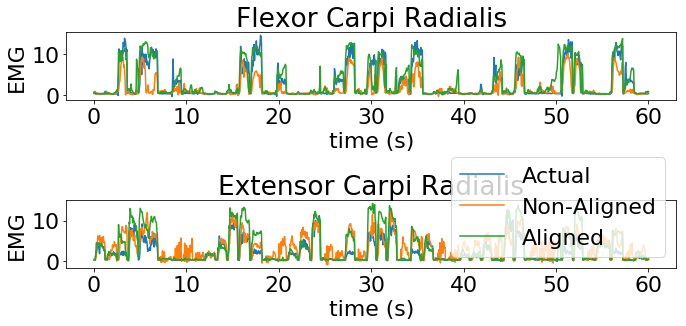

In [18]:
t = np.linspace(0., 60., 1200, endpoint=True)

plt.figure(figsize=(10,5), facecolor='white')

plt.subplot(2,1,1)
plt.plot(t,emg_dayk[:1200,0],t,emg_k_[:1200,0],t,emg_dayk_aligned[:1200,0])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Flexor Carpi Radialis')

plt.subplot(2,1,2)
plt.plot(t,emg_dayk[:1200,11],t,emg_k_[:1200,11],t,emg_dayk_aligned[:1200,11])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Extensor Carpi Radialis')
plt.legend(('Actual','Non-Aligned','Aligned'))

plt.tight_layout()
plt.show()